# Target Encoding

Most machine learning algorithms require the input data to be a numeric matrix, where each row is a sample and each column is a feature.  This makes sense for continuous features, where a larger number obviously corresponds to a larger value (features such as voltage, purchase amount, or number of clicks).  How to represent categorical features is less obvious.  Categorical features (such as state, merchant ID, domain name, or phone number) don't have an intrinsic ordering, and so most of the time we can't just represent them with random numbers.  Who's to say that Colorado is "greater than" Minnesota?  Or DHL "less than" FedEx?  To represent categorical data, we need to find a way to encode the categories numerically.

There are quite a few ways to encode categorical data.  We can simply assign each category an integer randomly (called label encoding).  Alternatively, we can create a new feature for each possible category, and set the feature to be 1 for each sample having that category, and otherwise set it to be 0 (called one-hot encoding).  If we're using neural networks, we could let our network learn the embeddings of categories in a high-dimensional space (called entity embedding, or in neural NLP models often just "embedding").

However, these methods all have drawbacks.  Label encoding doesn't work well at all with non-ordinal categorical features.  One-hot encoding leads to a humongous number of added features when your data contains a large number of categories.  Entity embedding can only be used with neural network models (or at least with models which are trained using stochastic gradient descent).

A different encoding method which we'll try in this post is called target encoding (also known as "mean encoding", and really should probably be called "mean target encoding").  With target encoding, each category is replaced with the mean target value for samples having that category.  The "target value" is the y-variable, or the value our model is trying to predict.  This allows us to encode an arbitrairy number of categories without increasing the dimensionality of our data!  

Of course, there are drawbacks to target encoding as well.  Target encoding introduces noise into the encoding of the categorical variables (noise which comes from the noise in the target variable itself).  Also, naively applying target encoding can allow data leakage, leading to overfitting and poor predictive performance.  To fix that problem, we'll have to construct target encoders which prevent data leakage.  And even with those leak-proof target encoders, there are situations where one would be better off using one-hot or other encoding methods.  One-hot can be better in situations with few categories, or with data where there are strong interaction effects.

In this post we'll evaluate different encoding schemes, build a cross-fold target encoder to mitigate the drawbacks of the naive target encoder, and determine how the performance of predictive models change based on the type of category encoding used, the number of categories in the dataset, and the presence of interaction effects. 

TODO: outline

First let's import the packages we'll be using.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import BayesianRidge
from xgboost import XGBRegressor

np.random.seed(12345)

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Data

To evaluate the effectiveness of different encoding algorithms, we'll want to be able to generate data with different numbers of samples, features, and categories.  Let's make a function to generate categorical datasets, which allows us to set these different aspects of the data.  The categories have a direct effect on the target variable which we'll try to predict.

In [0]:
def make_categorical_regression(n_samples=100,
                                n_features=10,
                                n_informative=10,
                                n_categories=10,
                                imbalance=0.0,
                                noise=1.0,
                                n_cont_features=0,
                                cont_weight=0.1,
                                interactions=0.0):
    """Generate a regression problem with categorical features.
  
    Parameters
    ----------
    n_samples : int > 0
        Number of samples to generate
        Default = 100
    n_features : int > 0
        Number of categorical features to generate
        Default = 10
    n_informative : int >= 0
        Number of features which carry information about the target.
        Default = 10
    n_categories : int > 0
        Number of categories per feature.  Default = 10
    imbalance : float > 0
        How much imbalance there is in the number of occurrences of
        each category.  Larger values yield a higher concentration
        of samples in only a few categories.  An imbalance of 0 
        yields the same number of samples in each category.
        Default = 0.0
    noise : float > 0
        Noise to add to target.  Default = 1.0
    n_cont_features : int >= 0
        Number of continuous (non-categorical) features.
        Default = 0
    cont_weight : float > 0
        Weight of the continuous variables' effect.
        Default = 0.1
    interactions : float >= 0 and <= 1
        Proportion of the variance due to interaction effects.
        Note that this only adds interaction effects between the 
        categorical features, not the continuous features.
        Default = 0.0
        
    Returns
    -------
    X : pandas DataFrame
        Features.  Of shape (n_samples, n_features+n_cont_features)
    y : pandas Series of shape (n_samples,)
        Target variable.
    """
    
    
    def beta_binomial(n, a, b):
        """Beta-binomial probability mass function.
        
        Parameters
        ----------
        n : int
            Number of trials
        a : float > 0
            Alpha parameter
        b : float > 0
            Beta parameter
            
        Returns
        -------
        ndarray of size (n,)
            Probability mass function.
        """
        from scipy.special import beta
        from scipy.misc import comb
        k = np.arange(n+1)
        return comb(n, k)*beta(k+a, n-k+b)/beta(a, b)


    # Check inputs
    if not isinstance(n_samples, int):
        raise TypeError('n_samples must be an int')
    if n_samples < 1:
        raise ValueError('n_samples must be one or greater')
    if not isinstance(n_features, int):
        raise TypeError('n_features must be an int')
    if n_features < 1:
        raise ValueError('n_features must be one or greater')
    if not isinstance(n_informative, int):
        raise TypeError('n_informative must be an int')
    if n_informative < 0:
        raise ValueError('n_informative must be non-negative')
    if not isinstance(n_categories, int):
        raise TypeError('n_categories must be an int')
    if n_categories < 1:
        raise ValueError('n_categories must be one or greater')
    if not isinstance(imbalance, float):
        raise TypeError('imbalance must be a float')
    if imbalance < 0:
        raise ValueError('imbalance must be non-negative')
    if not isinstance(noise, float):
        raise TypeError('noise must be a float')
    if noise < 0:
        raise ValueError('noise must be positive')
    if not isinstance(n_cont_features, int):
        raise TypeError('n_cont_features must be an int')
    if n_cont_features < 0:
        raise ValueError('n_cont_features must be non-negative')
    if not isinstance(cont_weight, float):
        raise TypeError('cont_weight must be a float')
    if cont_weight < 0:
        raise ValueError('cont_weight must be non-negative')
    if not isinstance(interactions, float):
        raise TypeError('interactions must be a float')
    if interactions < 0:
        raise ValueError('interactions must be non-negative')
        
    # Generate random categorical data (using category probabilities
    # drawn from a beta-binomial dist w/ alpha=1, beta=imbalance+1)
    cat_probs = beta_binomial(n_categories-1, 1.0, imbalance+1)
    categories = np.empty((n_samples, n_features), dtype='uint64')
    for iC in range(n_features):
        categories[:,iC] = np.random.choice(np.arange(n_categories),
                                            size=n_samples,
                                            p=cat_probs)
        
    # Generate random values for each category
    cat_vals = np.random.randn(n_categories, n_features)
    
    # Set non-informative columns' effect to 0
    cat_vals[:,:(n_features-n_informative)] = 0
    
    # Compute target variable from those categories and their values
    y = np.zeros(n_samples)
    for iC in range(n_features):
        y += (1.0-interactions) * cat_vals[categories[:,iC], iC]
      
    # Add interaction effects
    if interactions > 0:
        for iC1 in range(n_informative):
            for iC2 in range(iC1+1, n_informative):
                int_vals = np.random.randn(n_categories, #interaction
                                           n_categories) #effects
                y += interactions * int_vals[categories[:,iC1],
                                             categories[:,iC2]]
    
    # Add noise
    y += noise*np.random.randn(n_samples)
    
    # Generate dataframe from categories
    cat_strs = [''.join([chr(ord(c)+49) for c in str(n)]) 
                for n in range(n_categories)]
    X = pd.DataFrame()
    for iC in range(n_features):
        col_str = 'categorical_'+str(iC)
        X[col_str] = [cat_strs[i] for i in categories[:,iC]]
        
    # Add continuous features
    for iC in range(n_cont_features):
        col_str = 'continuous_'+str(iC)
        X[col_str] = cont_weight*np.random.randn(n_samples)
        y += np.random.randn()*X[col_str]
                    
    # Generate series from target
    y = pd.Series(data=y, index=X.index)
    
    # Return features and target
    return X, y

Now, we can easily generate data to test our encoders on:

In [3]:
# Generate categorical data and target
X, y = make_categorical_regression(n_samples=2000,
                                   n_features=10,
                                   n_categories=100,
                                   n_informative=1,
                                   imbalance=2.0)

# Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


The ten features in the dataset we generated are all categorical:

In [4]:
X_train.sample(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
792,cf,c,d,a,ed,ca,dj,g,b,bj
276,di,b,bd,fg,d,j,e,a,hc,h
1016,ei,di,cj,he,hb,gh,b,bh,df,c
1372,ca,c,be,ce,cg,bf,de,fe,ba,fd
1860,db,dh,ba,bh,di,bh,db,bi,gf,bi
1431,h,ce,ea,i,eb,g,da,da,fc,e
328,j,db,df,fa,fe,g,c,h,da,bg
1708,cd,ci,f,be,e,fb,dc,bi,ec,da
1567,ei,cj,ch,bc,bb,f,ch,bi,c,he
1027,bi,bh,bf,ba,dc,da,g,cc,bi,ee


Using the pandas package, these are stored as the "object" datatype:

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 523 to 583
Data columns (total 10 columns):
categorical_0    1000 non-null object
categorical_1    1000 non-null object
categorical_2    1000 non-null object
categorical_3    1000 non-null object
categorical_4    1000 non-null object
categorical_5    1000 non-null object
categorical_6    1000 non-null object
categorical_7    1000 non-null object
categorical_8    1000 non-null object
categorical_9    1000 non-null object
dtypes: object(10)
memory usage: 85.9+ KB


While all the features are categorical, the target variable is continuous:

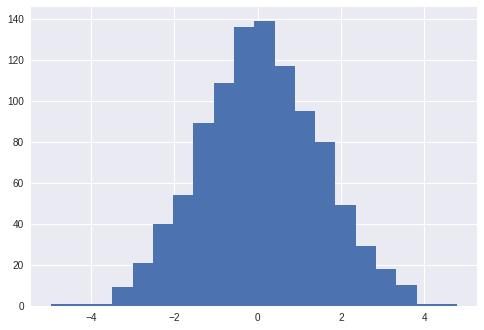

In [6]:
y_train.hist(bins=20)

Now the question is: which encoding scheme best allows us to glean the most information from the categorical features, leading to the best predictions of the target variable?

## Baseline

For comparison, how well would we do if we just predicted the mean target value for all samples?  We'll use the mean absolute error (MAE) as our performance metric.

In [7]:
mean_absolute_error(y_train, 
                    np.full(y_train.shape[0], y_train.mean()))

1.139564825988808

So our predictive models should definitely be shooting for a mean absolute error of less than that!  But, we added random noise with a standard deviation of 1, so even if our model is *perfect*, the best MAE we can expect is:

In [8]:
mean_absolute_error(np.random.randn(10000), 
                    np.zeros(10000))

0.7995403442995148

## Label Encoding

TODO: prediction w/ simple label encoding, which is just replacing each unique category w/ a unique integer

TODO: note that we could also use Scikit-learn's LabelEncoder

In [0]:
class LabelEncoder(BaseEstimator, TransformerMixin):
    """Label encoder.
    
    Replaces categorical column(s) with integer labels for each unique
    category in original column.

    """
    
    def __init__(self, cols=None):
        """Label encoder.
        
        Parameters
        ----------
        cols : list of str
            Columns to label encode.  Default is to label encode 
            all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit label encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Create the map from objects to integers for each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            self.maps[col] = dict(zip(
                X[col].values, 
                X[col].astype('category').cat.codes.values
            ))
                        
        # Return fit object
        return self

        
    def transform(self, X, y=None):
        """Perform the label encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
          
            # Map the column
            Xo[col] = Xo[col].map(tmap)
            
            # Convert to appropriate datatype
            max_val = max(tmap.values())
            if Xo[col].isnull().any(): #nulls, so have to use float!
                if max_val < 8388608:
                    dtype = 'float32'
                else:
                    dtype = 'float64'
            else:
                if max_val < 256:
                    dtype = 'uint8'
                elif max_val < 65536:
                    dtype = 'uint16'
                elif max_val < 4294967296:
                    dtype = 'uint32'
                else:
                    dtype = 'uint64'
            Xo[col] = Xo[col].astype(dtype)
            
        # Return encoded dataframe
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via label encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
        y : pandas Series, shape = [n_samples]
            Target values

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

Now we can convert the categories to integers:

In [10]:
# Label encode the categorical data
le = LabelEncoder()
X_label_encoded = le.fit_transform(X_train, y_train)
X_label_encoded.sample(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
884,13,40,83,5,82,32,44,6,23,55
1098,15,66,34,70,56,36,69,3,86,48
853,56,6,12,30,27,25,56,10,54,6
1667,17,6,77,8,22,65,22,33,5,22
1136,56,5,8,34,0,31,48,80,50,56
362,0,15,47,50,42,7,9,3,81,34
1977,21,19,22,56,56,13,1,43,13,34
1784,35,66,37,66,4,1,76,8,1,10
127,82,42,11,63,12,39,58,76,59,67
1489,2,66,35,1,4,1,45,24,23,24


But again, these integers aren't related to the categories in any meaningful way - aside from the fact that each unique integer corresponds to a unique category.

TODO: then we can make a model to predict

In [11]:
# Regression model
model_le = Pipeline([
    ('label-encoder', LabelEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', BayesianRidge())
])

# Cross-validated MAE
mae_scorer = make_scorer(mean_absolute_error)
scores = cross_val_score(model_le, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 1.13197409773137 +/- 0.021768461339780148


TODO: That's not much better than just predicting the mean!

However, the error is no worse on the test data than the cross-validated error on the training data.



In [12]:
# MAE on test data
model_le.fit(X_train, y_train)
y_pred = model_le.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)

Validation MAE: 1.175866100844089


## One-hot Encoding

TODO: one-hot encoding, sometimes aka "Dummy encoding"

(note that we could also use Scikit-learn's OneHotEncoder)

In [0]:
class OneHotEncoder(BaseEstimator, TransformerMixin):
    """One-hot encoder.
    
    Replaces categorical column(s) with binary columns for each unique
    value in original column.

    """
    
    def __init__(self, cols=None, reduce_df=False):
        """One-hot encoder.
        
        Parameters
        ----------
        cols : list of str
            Columns to one-hot encode.  Default is to one-hot encode 
            all categorical columns in the DataFrame.
        reduce_df : bool
            Whether to add N-1 one-hot columns for a column with N 
            categories. E.g. for a column with categories A, B, and C:
            When reduce_df is True, A=[1, 0], B=[0, 1], and C=[0, 0]
            When reduce_df is False, A=[1, 0, 0], B=[0, 1, 0], and 
            C=[0, 0, 1]
            Default = False
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        self.reduce_df = reduce_df
        
        
    def fit(self, X, y):
        """Fit one-hot encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Store each unique value
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            self.maps[col] = []
            uniques = X[col].unique()
            for unique in uniques:
                self.maps[col].append(unique)
            if self.reduce_df:
                del self.maps[col][-1]
        
        # Return fit object
        return self

        
    def transform(self, X, y=None):
        """Perform the one-hot encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to one-hot encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, vals in self.maps.items():
            for val in vals:
                new_col = col+'_'+str(val)
                Xo[new_col] = (Xo[col]==val).astype('uint8')
            del Xo[col]
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via one-hot encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to one-hot encode
        y : pandas Series, shape = [n_samples]
            Target values

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

Now, instead of replacing categories with integer labels, we've create a new column for each category in each original column.  The value in a given column is 1 when the original category matches, otherwise the value is 0.

In [14]:
# One-hot-encode the categorical data
ohe = OneHotEncoder()
X_one_hot = ohe.fit_transform(X_train, y_train)
X_one_hot.sample(10)

,categorical_0_ec,categorical_0_ba,categorical_0_bg,categorical_0_b,categorical_0_h,categorical_0_j,categorical_0_ge,categorical_0_cg,categorical_0_fh,categorical_0_dc,...,categorical_9_ga,categorical_9_eb,categorical_9_gg,categorical_9_hj,categorical_9_gi,categorical_9_he,categorical_9_ff,categorical_9_hb,categorical_9_gd,categorical_9_fi
294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
382,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can fit the same model with the one-hot encoded data as we fit to the label-encoded data.

In [15]:
# Regression model
model_oh = Pipeline([
    ('encoder', OneHotEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', BayesianRidge())
])

# Cross-validated MAE
scores = cross_val_score(model_oh, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 1.0386222429286203 +/- 0.028114652268138147


TODO: better than just guessing the mean, but not by a whole lot!

In [16]:
# MAE on test data
model_oh.fit(X_train, y_train)
y_pred = model_oh.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)

Validation MAE: 1.028751865940599


## Target Encoding

TODO: target encoding replaces categorical vals w/ the mean of the target for that category; explain w/ diagrams

In [0]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target encode all 
            categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

Now, instead of creating a bazillion columns (like with one-hot encoding), we can simply replace each category with the mean target value for that category.  This allows us to represent the categorical information in the same dimensionality, while retaining some information about the categories.  By target-encoding the features matrix, we get a matrix of the same size, but filled with continuous values instead of categories:

In [18]:
# Target encode the categorical data
te = TargetEncoder()
X_target_encoded = te.fit_transform(X_train, y_train)
X_target_encoded.sample(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
711,-0.030636,0.192812,0.269273,0.131628,0.319769,0.190861,0.142159,0.393587,-0.766454,-0.312227
475,0.365423,-0.605778,-0.258930,0.038321,-0.283131,0.046135,0.316052,-0.120822,-0.425927,-0.163454
273,0.110462,1.093313,0.309760,0.474308,0.090909,0.003120,1.558923,0.244971,-0.387846,-0.327537
9,-0.848020,0.300673,0.125095,-0.650361,-0.252932,0.293856,-0.197504,0.050085,-0.587633,-0.413439
275,0.126068,0.180776,-0.143977,-0.131238,0.090909,-0.760367,0.326620,-0.037488,-0.121713,-0.244310
336,0.543412,-0.045947,0.180144,0.279675,-0.532591,0.338287,0.071977,0.113531,0.527567,1.290724
1462,-0.065061,-0.605778,0.172445,-0.268622,-0.283131,-0.270112,-0.197504,0.068821,0.371461,0.966579
1436,0.186988,0.564015,0.135396,0.474308,0.338006,0.479294,0.063384,0.342170,-0.054090,-0.163454
1611,0.350326,-0.188197,-0.537682,-0.391143,0.212399,-1.811086,0.204642,-0.622682,-0.425927,-0.489371
166,0.480637,0.975462,0.135396,-0.131238,0.323870,0.279502,-0.533179,0.050085,0.016449,1.410449


Note that the size of our target-encoded matrix is the same size as the original (unlike the huge one-hot transformed matrix):

In [19]:
# Compare sizes
print('Original size:', X_train.shape)
print('Target encoded size:', X_target_encoded.shape)

Original size: (1000, 10)
Target encoded size: (1000, 10)


Also, each column has exactly as many unique continuous values as it did categories.  This is because we've simply replaced the category with the mean target value for that category.

In [20]:
# Compare category counts
print('Original:')
print(X_train.nunique())
print('\nTarget encoded:')
print(X_target_encoded.nunique())

Original:
categorical_0    84
categorical_1    81
categorical_2    85
categorical_3    88
categorical_4    84
categorical_5    86
categorical_6    88
categorical_7    88
categorical_8    90
categorical_9    79
dtype: int64

Target encoded:
categorical_0    84
categorical_1    81
categorical_2    85
categorical_3    88
categorical_4    84
categorical_5    86
categorical_6    88
categorical_7    88
categorical_8    90
categorical_9    79
dtype: int64


If we fit the same model as before, but now after target-encoding the categories, our predictions get much better!

In [21]:
# Regression model
model_te = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', BayesianRidge())
])

# Cross-validated MAE
scores = cross_val_score(model_te, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 0.9402165006761526 +/- 0.029713106940791913


The performance on the test data is about the same, but slightly better, because we've given it more samples on which to train.


In [22]:
# MAE on test data
model_te.fit(X_train, y_train)
y_pred = model_te.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)

Validation MAE: 0.9325682408250325


While the error is lower using target encoding than with one-hot encoding, in naively target-encoding our categories, we've introduced a data leak from the target variable for one sample into the features for that same sample!  

TODO: explain w/ diagrams

Leaking the target variable into our predictors causes our learning algorithm to over-depend on the target-encoded features, and overfit the data.  Although we gain predictive power by keeping the dimensionality of our training data reasonable, we loose nearly all of that gain by allowing our model to overfit to the target-encoded columns!

## Cross-Fold Target Encoding

To clamp down on the data leakage, we need to ensure that we're not using the using the target value from a given sample to compute its target-encoded values.  However, we can still use *other* samples in the training data to compute the mean target values for *this* sample's category.  

There are a few different ways we can do this.  We could compute the per-category target means in a cross-fold fashion, or by leaving current sample out (leave-one-out).

TODO: explain cross-fold w /diagrams

In [0]:
class TargetEncoderCV(TargetEncoder):
    """Cross-validated target encoder.
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-validated target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-validation splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cols = cols
        

    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-validated target encoding for the training fold, and uses
        normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:], y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

With this encoder, we can convert the categories into continuous values, just like we did with the naive target encoding.

In [24]:
# Cross-fold Target encode the categorical data
te = TargetEncoderCV()
X_target_encoded_cv = te.fit_transform(X_train, y_train)
X_target_encoded_cv.sample(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
236,0.233017,0.266851,0.620411,-0.0917691,0.0238002,0.205387,-0.182844,0.209843,-0.201101,1.95302
103,0.0419825,-0.133423,-0.152355,0.768532,-0.105238,-0.0010254,-0.0768051,-0.164632,-0.108223,-1.16817
502,0.335987,0.686906,0.00831367,0.780618,0.253249,-0.588782,-0.0104415,-0.139042,0.258339,2.08561
870,0.251286,-0.221214,-0.21522,-0.528595,-0.320334,0.484078,0.593479,0.131563,0.152882,-0.333682
357,-0.105762,-0.108175,-0.2422,-1.08681,-0.0790136,-0.367782,0.287205,0.542695,0.064133,-0.670692
1372,0.169969,0.366924,0.399639,-0.0954622,0.0220233,-0.588782,-0.529951,0.233605,-0.260713,-0.130225
620,0.372039,0.110516,-0.259249,-0.0814691,0.294292,0.705151,0.300228,0.227451,0.185972,1.53523
1147,-0.294882,0.477974,0.531971,0.210054,-0.171589,-0.106227,0.0837924,-0.201896,-0.595051,0.659421
1650,-0.882803,0.647945,0.177125,-0.190479,0.644579,0.208487,0.657135,0.227451,-0.701029,-0.00746989
68,NaN,0.831874,-0.113836,-0.190479,-0.475449,-1.90497,-0.991536,0.649424,-0.326514,-0.2205


Like with normal target encoding, our transformed matrix is the same shape as the original:

In [25]:
# Compare sizes
print('Original size:', X_train.shape)
print('Target encoded size:', X_target_encoded_cv.shape)

Original size: (1000, 10)
Target encoded size: (1000, 10)


However, now we have more unique continuous values in each column than we did categories, because we've target-encoded the categories separately for each fold.

In [26]:
# Compare category counts
print('Original:')
print(X_train.nunique())
print('\nTarget encoded:')
print(X_target_encoded_cv.nunique())

Original:
categorical_0    84
categorical_1    81
categorical_2    85
categorical_3    88
categorical_4    84
categorical_5    86
categorical_6    88
categorical_7    88
categorical_8    90
categorical_9    79
dtype: int64

Target encoded:
categorical_0    214
categorical_1    203
categorical_2    201
categorical_3    203
categorical_4    208
categorical_5    207
categorical_6    207
categorical_7    205
categorical_8    213
categorical_9    200
dtype: int64


TODO: then we can fit the same model as before, but w/ cross-fold target encoding...

In [27]:
# Regression model
model_te_cv = Pipeline([
    ('encoder', TargetEncoderCV()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', BayesianRidge())
])

# Cross-validated MAE
scores = cross_val_score(model_te_cv, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 0.8351049783190474 +/- 0.04365424683197591


TODO: and now the validation performance is consistent with the cross-validated performance

In [28]:
# MAE on test data
model_te_cv.fit(X_train, y_train)
y_pred = model_te_cv.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)

Validation MAE: 0.8389909316238072


## Leave-one-out Target Encoding

We could also prevent the target data leakage by using a leave-one-out scheme.  With this method, we compute the per-category means as before, but we don't include the current sample in the computation.

TODO: explain w/ diagrams

In [0]:
class TargetEncoderLOO(TargetEncoder):
    """Leave-one-out target encoder.
    """
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Leave-one-out target encoding for categorical features.
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.
        """
        self.cols = cols
        

    def fit(self, X, y):
        """Fit leave-one-out target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to target encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.sum_count = dict() #dict for sum + counts for each column
        for col in self.cols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = (y[ix].sum(), ix.sum())
            
        # Return the fit object
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses leave-one-out target encoding for the training fold, and
        uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        # Create output dataframe
        Xo = X.copy()

        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = sum_count[0]/sum_count[1]
                Xo[col] = vals

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    vals[ix] = (sum_count[0]-y[ix])/(sum_count[1]-1)
                Xo[col] = vals
            
        # Return encoded DataFrame
        return Xo
      
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [30]:
# Cross-fold Target encode the categorical data
te = TargetEncoderLOO()
X_target_encoded_loo = te.fit_transform(X_train, y_train)
X_target_encoded_loo.sample(10)

,categorical_0,categorical_1,categorical_2,categorical_3,categorical_4,categorical_5,categorical_6,categorical_7,categorical_8,categorical_9
915,-0.012727,0.314121,-0.233903,0.175900,0.132491,-1.140074,0.069677,0.256593,-0.430652,-0.103827
1647,0.215025,0.394832,-0.449700,0.600029,-0.201291,0.260293,0.191454,-2.622372,0.165401,NaN
82,-0.025525,-0.097241,0.306800,0.302967,0.211843,-0.075201,0.487799,-0.062378,0.137296,-0.608199
328,-0.022190,0.183942,0.237844,-0.622328,-0.305189,0.444699,0.145842,0.451886,0.397333,0.897512
369,0.612622,-0.219190,0.430788,0.595137,-0.299720,-0.210595,-0.073953,-0.153809,0.342509,0.827628
1488,0.158465,-0.104834,0.117011,1.055839,0.071813,-0.166491,-0.598097,0.394334,-0.909585,-0.650951
800,0.287101,-0.072489,0.402740,-0.044492,0.157021,0.542464,0.601372,0.215462,0.184972,-2.275490
735,0.050074,0.252479,-0.164370,-0.143356,0.126941,0.417575,0.044603,-0.167643,NaN,-0.427960
1361,0.572234,0.578534,-0.286133,0.142657,-0.537536,-0.144131,1.009878,0.019303,-0.524030,0.880222
1355,-0.188658,-0.107702,0.052277,-0.121903,0.130991,-0.264774,0.082149,0.031939,0.136631,0.335117


The transformed matrix is stil the same size as the original:

In [31]:
# Compare sizes
print('Original size:', X_train.shape)
print('Target encoded size:', X_target_encoded_loo.shape)

Original size: (1000, 10)
Target encoded size: (1000, 10)


But now there are nearly as many unique values in each column as there are samples:

In [32]:
# Compare category counts
print('Original:')
print(X_train.nunique())
print('\nLeave-one-out target encoded:')
print(X_target_encoded_loo.nunique())

Original:
categorical_0    84
categorical_1    81
categorical_2    85
categorical_3    88
categorical_4    84
categorical_5    86
categorical_6    88
categorical_7    88
categorical_8    90
categorical_9    79
dtype: int64

Leave-one-out target encoded:
categorical_0    993
categorical_1    994
categorical_2    992
categorical_3    987
categorical_4    990
categorical_5    990
categorical_6    990
categorical_7    991
categorical_8    992
categorical_9    996
dtype: int64


In [33]:
# Regression model
model_te_loo = Pipeline([
    ('encoder', TargetEncoderLOO()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', BayesianRidge())
])

# Cross-validated MAE
scores = cross_val_score(model_te_loo, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('Cross-validated MAE:', scores.mean(), '+/-', scores.std())

Cross-validated MAE: 0.8329997501949703 +/- 0.037514587474735996


In [34]:
# MAE on test data
model_te_loo.fit(X_train, y_train)
y_pred = model_te_loo.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print('Validation MAE:', test_mae)

Validation MAE: 0.837977841124484


The leave-one-out target encoder performs *slightly* better than the cross-fold target encoder, because we've given it more samples with which to compute the per-category means ($N-1$, instead of $N-N/K$, where K is the number of folds).  While the increase in performance was very small, the leave-one-out target encoder is faster, due to the effecient way we computed the leave-one-out means (instead of having to compute means for each fold).

In [35]:
%%time
Xo = TargetEncoderCV().fit_transform(X_train, y_train)

CPU times: user 6.81 s, sys: 105 ms, total: 6.92 s
Wall time: 6.83 s


In [36]:
%%time
Xo = TargetEncoderLOO().fit_transform(X_train, y_train)

CPU times: user 4.23 s, sys: 17.1 ms, total: 4.25 s
Wall time: 4.25 s


## Effect of the Learning Algorithm

The increase in predictive performance one gets from target encoding depends on the machine learning algorithm which is using it.  As we've seen, target encoding is great for linear models (throughout this post we were using a Bayesian ridge regression, a variant on a linear regression which optimizes the regularization parameter).  However, target encoding doesn't help as much for tree-based boosting algorithms like XGBoost, CatBoost, or LightGBM, which tend to handle categorical data pretty well as-is.

Fitting the Bayesian ridge regression to the data, we see a huge increase in performance after target encoding (relative to one-hot encoding).

In [37]:
# Bayesian ridge w/ one-hot encoding
model_brr = Pipeline([
    ('encoder', OneHotEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', BayesianRidge())
])

# Cross-validated MAE
scores = cross_val_score(model_brr, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('MAE w/ Bayesian Ridge + one-hot encoding: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

MAE w/ Bayesian Ridge + one-hot encoding: 1.039 +/- 0.028


In [38]:
# Bayesian ridge w/ target-encoding
model_brr = Pipeline([
    ('encoder', TargetEncoderLOO()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', BayesianRidge())
])

# Cross-validated MAE
scores = cross_val_score(model_brr, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('MAE w/ Bayesian Ridge + target encoding: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

MAE w/ Bayesian Ridge + target encoding: 0.833 +/- 0.038


However, using XGBoost, there is only a modest perfomance increase (if any at all).

In [39]:
# Regression model
model_xgb = Pipeline([
    ('encoder', OneHotEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', XGBRegressor())
])

# Cross-validated MAE
scores = cross_val_score(model_xgb, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('MAE w/ XGBoost + one-hot encoding: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

MAE w/ XGBoost + one-hot encoding: 0.869 +/- 0.040


In [40]:
# Regression model
model_xgb = Pipeline([
    ('encoder', TargetEncoderLOO()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', XGBRegressor())
])

# Cross-validated MAE
scores = cross_val_score(model_xgb, X_train, y_train, 
                         cv=3, scoring=mae_scorer)
print('MAE w/ XGBoost + target encoding: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

MAE w/ XGBoost + target encoding: 0.864 +/- 0.052


## Dependence on the Number of Categories

There is also an effect of the number of categories on the performance of a model trained on target-encoded data.  Target encoding works well with categorical data that contains a large number of categories.  However, if you have data with only a few categories, you're probably better off using one-hot encoding.

For example, let's generate two datasets: one which has a large number of categories in each column, and another which has only a few categories in each column.

In [41]:
# Categorical data w/ many categories
X_many, y_many = make_categorical_regression(
    n_samples=1000, 
    n_features=10, 
    n_categories=100,
    n_informative=1,
    imbalance=2.0)

# Categorical data w/ few categories
X_few, y_few = make_categorical_regression(
    n_samples=1000, 
    n_features=10, 
    n_categories=5,
    n_informative=1,
    imbalance=2.0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


Then we'll construct two separate models: one which uses target-encoding, and another which uses one-hot encoding.

In [0]:
# Regression model w/ target encoding
model_te = Pipeline([
    ('encoder', TargetEncoderLOO()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', BayesianRidge())
])

# Regression model w/ one-hot encoding
model_oh = Pipeline([
    ('encoder', OneHotEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', BayesianRidge())
])

On the dataset with many categories per column, target-encoding outperforms one-hot encoding by a good margin.

In [43]:
print('Many categories:')

# Target encoding w/ many categories
scores = cross_val_score(model_te, X_many, y_many, 
                         cv=3, scoring=mae_scorer)
print('MAE w/ target encoding: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

# One-hot encoding w/ many categories
scores = cross_val_score(model_oh, X_many, y_many, 
                         cv=3, scoring=mae_scorer)
print('MAE w/ one-hot encoding: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

Many categories:
MAE w/ target encoding: 0.820 +/- 0.029
MAE w/ one-hot encoding: 1.049 +/- 0.045


On the other hand, with the dataset containing only a few categories per column, the performance of the one-hot encoded model is nearly indistinguishable from the performance of the model which uses target encoding.

In [44]:
print('Few categories:')

# Target encoding w/ few categories
scores = cross_val_score(model_te, X_few, y_few, 
                         cv=3, scoring=mae_scorer)
print('MAE w/ target encoding: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

# One-hot encoding w/ few categories
scores = cross_val_score(model_oh, X_few, y_few, 
                         cv=3, scoring=mae_scorer)
print('MAE w/ one-hot encoding: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

Few categories:
MAE w/ target encoding: 0.815 +/- 0.030
MAE w/ one-hot encoding: 0.830 +/- 0.025


## Effect of Category Imbalance

I would have expected target encoding to perform better than one-hot encoding when the categories were extremely unbalanced (most samples have one of only a few categories), and one-hot encoding to outperform target encoding in the case of balanced categories (categories appear about the same number of times thoughout the dataset).  However, it appears that category imbalance effects both one-hot and target encoding similarly.  

Let's generate two datasets, one of which has balanced categories, and another which has highly imbalanced categories in each column.

In [45]:
# Categorical data w/ many categories
X_bal, y_bal = make_categorical_regression(
    n_samples=1000, 
    n_features=10, 
    n_categories=100,
    n_informative=1,
    imbalance=0.0)

# Categorical data w/ few categories
X_imbal, y_imbal = make_categorical_regression(
    n_samples=1000, 
    n_features=10, 
    n_categories=100,
    n_informative=1,
    imbalance=2.0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


Fitting the models from the previous section (one of which uses target encoding and the other uses one-hot encoding), we see that how imbalanced the data is doesn't have a huge effect on the perfomance of the model which uses target encoding.

In [46]:
print('Target encoding:')

# Target encoding w/ imbalanced categories
scores = cross_val_score(model_te, X_imbal, y_imbal, 
                         cv=5, scoring=mae_scorer)
print('MAE w/ imbalanced categories: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

# Target encoding w/ balanced categories
scores = cross_val_score(model_te, X_bal, y_bal, 
                         cv=5, scoring=mae_scorer)
print('MAE w/ balanced categories: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

Target encoding:
MAE w/ imbalanced categories: 0.873 +/- 0.054
MAE w/ balanced categories: 0.845 +/- 0.041


Nor does it appear to have a big effect on the performance of the model which uses one-hot encoding.

In [47]:
print('One-hot encoding:')

# One-hot encoding w/ imbalanced categories
scores = cross_val_score(model_oh, X_imbal, y_imbal, 
                         cv=5, scoring=mae_scorer)
print('MAE w/ imbalanced categories: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

# One-hot encoding w/ balanced categories
scores = cross_val_score(model_oh, X_bal, y_bal, 
                         cv=5, scoring=mae_scorer)
print('MAE w/ balanced categories: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

One-hot encoding:
MAE w/ imbalanced categories: 1.030 +/- 0.024
MAE w/ balanced categories: 0.993 +/- 0.029


I've tried various combinations of predictive models, levels of imbalance, and numbers of categories, and the level of imbalance doesn't seem to have a very systematic effect.  I suspect this is because for both target encoding and one-hot encoding, with balanced categories we have more information about all categories on average (because examples with each category are more evenly distributed).  On the other hand, we have *less* information about the most common categories - because those categories are no more "common" than any other in a balanced dataset.  Therefore, the level of uncertainty for those categories ends up actually being higher for balanced datasets.  Those two effects appear to cancel out, and the predictive performance of our models don't change.

## Effect of Interactions

So far, target encoding has performed as well or better than other types of encoding.  However, there's one situation where target encoding doesn't do so well: in the face of strong interaction effects.

An interaction effect is when the effect of one feature on the target variable depends on the value of a second feature.  For example, suppose we have one categorical feature with categories A and B, and a second categorical feature with categories C and D.  With no interaction effect, the effect of the first and second feature would be additive, and the effect of A and B on the target variable is independent of C and D.  An example of this is the money spent as a function of items purchased.  If a customer purchases both items 1 and 2, they will be charged the same as if they had purchased either item independently:

([<matplotlib.axis.XTick at 0x7f7ab683cc88>,
 <a list of 4 Text xticklabel objects>)

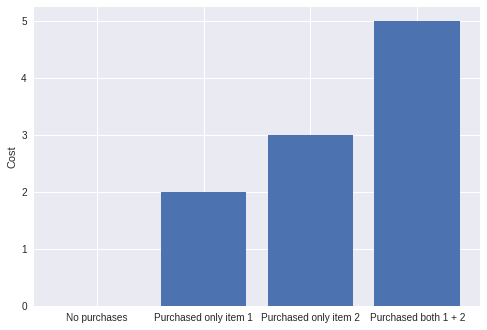

In [68]:
plt.bar(np.arange(4), [0, 2, 3, 5])
plt.ylabel('Cost')
plt.xticks(np.arange(4), 
           ['No purchases', 
            'Purchased only item 1', 
            'Purchased only item 2', 
            'Purchased both 1 + 2'])

On the other hand, if there is an interaction effect, the effect on the target variable will not be simply the sum of the two features' effects.  For example, just adding sugar *or* stirring coffee may not have a huge effect on the sweetness of the coffee.  But if one adds sugar *and* stirs, there is a large effect on the sweetness of the coffee.

([<matplotlib.axis.XTick at 0x7f7ab6651400>,
 <a list of 4 Text xticklabel objects>)

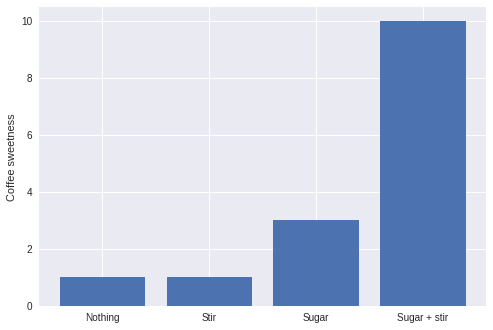

In [70]:
plt.bar(np.arange(4), [1, 1, 3, 10])
plt.ylabel('Coffee sweetness')
plt.xticks(np.arange(4), 
           ['Nothing', 
            'Stir', 
            'Sugar', 
            'Sugar + stir'])


Target encoding simply fills in each category with the mean target value for samples having that category.  Because target encoding does this for each column individually, it's fundamentally unable to  handle interactions between columns!  That said, one-hot encoding doesn't intrinsically handle interaction effects either - it depends on the learning algorithm being used.  Linear models (like the Bayesian ridge regression we've been using) can't pull out interaction effects unless we explicitly encode them (by adding a column for each possible interaction).  Nonlinear learning algorithms, such as decision tree-based models, SVMs, and neural networks, are able to detect interaction effects in the data as-is.

To see how well interaction effects are captured by models trained on target-encoded or one-hot-encoded data, we'll create two categorical datasets: one which has no interaction effects, and one whose variance is completely explained by interaction effects (and noise).

In [56]:
# Categorical data w/ no interaction effects
X_no_int, y_no_int = make_categorical_regression(
    n_samples=1000, 
    n_features=10,
    n_categories=100,
    n_informative=2,
    interactions=0.0)

# Categorical data w/ interaction effects
X_inter, y_inter = make_categorical_regression(
    n_samples=1000, 
    n_features=10,
    n_categories=100,
    n_informative=2,
    interactions=1.0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.


To capture interaction effects, we'll have to use a model which can handle interactions, such as a tree-based method like XGBoost (a linear regression can't capture interactions unless they are explicitly encoded).

In [0]:
# Regression model w/ target encoding
model_te = Pipeline([
    ('encoder', TargetEncoderLOO()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', XGBRegressor())
])

# Regression model w/ one-hot encoding
model_oh = Pipeline([
    ('encoder', OneHotEncoder()),
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('regressor', XGBRegressor())
])

As we've seen before, without interaction effects the target encoder performs better than the one-hot encoder.

In [61]:
print('No interaction effects:')

# Target encoding w/ no interaction effects
scores = cross_val_score(model_te, X_no_int, y_no_int, 
                         cv=5, scoring=mae_scorer)
print('MAE w/ target encoding: %0.3f +/- %0.3f'
      % (scores.mean(), scores.std()))

# One-hot encoding w/ no interaction effects
scores = cross_val_score(model_oh, X_no_int, y_no_int, 
                         cv=5, scoring=mae_scorer)
print('MAE w/ one-hot encoding: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

No interaction effects:
MAE w/ target encoding: 0.981 +/- 0.058
MAE w/ one-hot encoding: 1.119 +/- 0.065


However, when most of the variance can be explained by interaction effects, the model trained on one-hot encoded data performs better (or at least it's unlikely that the target-encoded model has better performance).

In [62]:
print('With interaction effects:')

# Target encoding w/ interaction effects
scores = cross_val_score(model_te, X_inter, y_inter, 
                         cv=5, scoring=mae_scorer)
print('MAE w/ target encoding: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

# One-hot encoding w/ interaction effects
scores = cross_val_score(model_oh, X_inter, y_inter, 
                         cv=5, scoring=mae_scorer)
print('MAE w/ one-hot encoding: %0.3f +/- %0.3f' 
      % (scores.mean(), scores.std()))

With interaction effects:
MAE w/ target encoding: 1.240 +/- 0.052
MAE w/ one-hot encoding: 1.184 +/- 0.058


## Suggestions

Target encoding categorical variables is a great way to represent categorical data in a numerical format that machine learning algorithms can handle, without jacking up the dimensionality of your training data.  However, make sure to use cross-fold or leave-one-out target encoding to prevent data leakage!  Also keep in mind the number of categories, what machine learning algorithm you're using, and whether you suspect there may be strong interaction effects in your data.  With only a few categories, or in the presence of interaction effects, you're probably better off just using one-hot encoding and a boosting algorithm like XGBoost/CatBoost/LightGBM.  On the other hand, if your data contains many columns with many categories, it might be best to use target encoding!